# Visualize SAIL data

In [1]:
# Import packages
from soslib import funcs
import act
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import pytz


nctoolkit is using Climate Data Operators version 2.1.0


# Download necessary ECOR, CEIL, and SEBS data

In [101]:
# User and token for pulling in data
new_user=False
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")

ecor_kp = 'guc30ecorS3.b1'
sebs = 'gucsebsS3.b1'
start = '2021-10-01'
end = '2023-02-01' 

if new_user:
    ecor_ds = funcs.get_sail_data(username,token,ecor_kp,start,end)
    sebs_ds = funcs.get_sail_data(username,token,sebs,start,end)
else:
    # If this was already downloaded, we just need to access the files
    ecor_ds = xr.open_dataset('/storage/dlhogan/sos/data/ecor_kp.nc')
    sebs_ds = xr.open_dataset('/storage/dlhogan/sos/data/sebs_kp.nc')

In [9]:
def add_local_time(ds):
    time_utc = ds['time'].to_index().tz_localize(pytz.UTC)
    us_mtn = pytz.timezone('US/Mountain')
    tz_corrected = time_utc.tz_convert(us_mtn).tz_localize(None)
    local_da=xr.DataArray.from_series(tz_corrected)
    ds.coords.update({'local_time':tz_corrected})
    return ds

In [ ]:
# Quick check on how much ecor data we are missing by month
((ecor_ds['wind_dir'].isnull().groupby(ecor_ds.time.dt.month).sum()/ecor_ds['wind_dir'].isnull().groupby(ecor_ds.time.dt.month).count())*100).values

In [18]:
# add local time and create dataframe
ecor_df = add_local_time(ecor_ds['wind_dir'].where(ecor_ds['qc_wind_dir']==0)).to_dataframe()
sebs_df = add_local_time(sebs_ds['down_short_hemisp'].where(sebs_ds['qc_down_short_hemisp']==0)).to_dataframe()
ecor_df = ecor_df.set_index('local_time')
sebs_df = sebs_df.set_index('local_time')

In [47]:
# Iterate to create the dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in ecor_df.index.month.unique():
    a = ecor_df[ecor_df.index.month == month]['wind_dir']
    a = a.groupby(a.index.hour).median()
    a.name=month
    tmp.append(a)
ecor_ds_hourly = pd.concat(tmp, axis=1).T

tmp=[]
for month in sebs_df.index.month.unique():
    a = sebs_df[sebs_df.index.month == month]['down_short_hemisp']
    a = a.groupby(a.index.hour).mean()
    a.name=month
    tmp.append(a)
sebs_ds_hourly = pd.concat(tmp, axis=1).T

In [51]:
# Sort for plotting
sebs_ds_hourly = sebs_ds_hourly.fillna(0).sort_index()
ecor_ds_hourly = ecor_ds_hourly.sort_index()

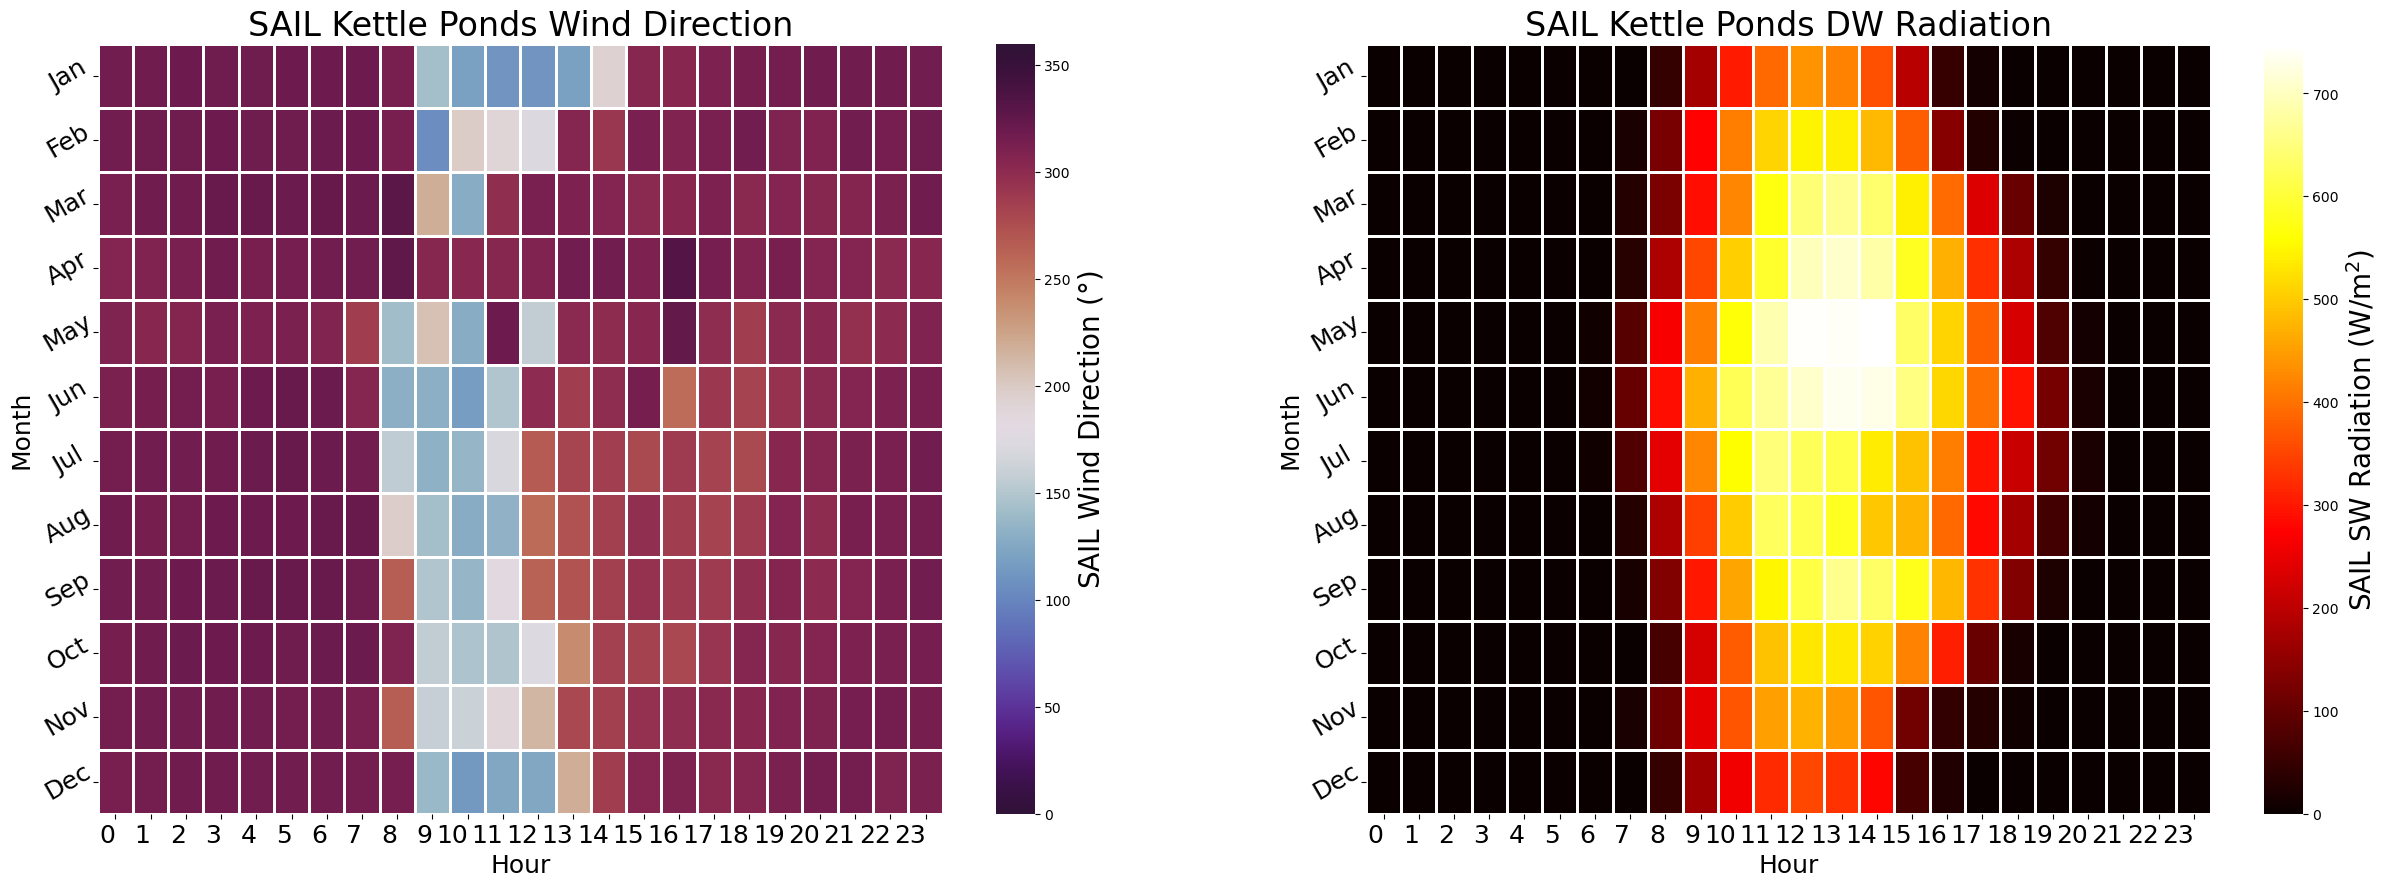

In [55]:
import seaborn as sns
fig, axs=plt.subplots(ncols=2,figsize=(30,10), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(ecor_ds_hourly, cmap='twilight_shifted', vmin=0, vmax=360,linewidths=2, cbar_kws={'label':'SAIL Wind Direction ($\degree$)'}, ax=axs[0])
axs[0].set_xticklabels(ecor_ds_hourly.columns, rotation=0, ha='right', size=18);
axs[0].set_yticklabels(months, rotation=30, ha='center', size=18);
axs[0].tick_params(axis='y', which='major', pad=18)
axs[0].set_xlabel('Hour',size=18)
axs[0].set_ylabel('Month', size=18)
axs[0].set_title('SAIL Kettle Ponds Wind Direction', size=24)
axs[0].figure.axes[-1].yaxis.label.set_size(20)

sns.heatmap(sebs_ds_hourly, cmap='hot',linewidths=2, cbar_kws={'label':'SAIL SW Radiation (W/m$^2$)'}, ax=axs[1])
axs[1].set_xticklabels(sebs_ds_hourly.columns, rotation=0, ha='right', size=18);
axs[1].set_yticklabels(months, rotation=30, ha='center', size=18);
axs[1].tick_params(axis='y', which='major', pad=18)
axs[1].set_xlabel('Hour',size=18)
axs[1].set_ylabel('Month', size=18)
axs[1].set_title('SAIL Kettle Ponds DW Radiation', size=24)
axs[1].figure.axes[-1].yaxis.label.set_size(20)

### Plot Ceilometer hovmoller

In [ ]:

# Grab ceilometer data
ceil ='gucceilM1.b1'
starts = ['2021-10-01','2022-01-01','2022-04-01','2022-07-01','2022-11-01']
ends = ['2022-01-01','2022-04-01','2022-07-01','2022-11-01','2023-02-01']
i=0
if new_user:
    for s, e in zip(starts, ends):
        print(f'Working on {s} to {e}') 
        ceil_ds = funcs.get_sail_data(username,token,ceil,s,e)

        tmp = ceil_ds[['detection_status',
                    'status_flag',
                    'first_cbh',
                    'qc_first_cbh',
                    'second_cbh',
                    'qc_second_cbh',
                    'third_cbh',
                    'qc_third_cbh']]
        tmp_hourly = tmp.resample(time='1H').mean()
        tmp_hourly.to_netcdf(f'/storage/dlhogan/sos/data/ceilometer/ceil_0{i}.nc')
        i+=1
    else:
        ceil_ds = xr.open_mfdataset('/storage/dlhogan/sos/data/ceilometer/*.nc')

In [74]:
ceil_df = add_local_time(ceil_ds).to_dataframe()
ceil_df = ceil_df.set_index('local_time')
ceil_df['cloud_detect'] = ceil_df['detection_status']
# use this to filter out multiple cloud detects and just make them equal to a cloud detection
ceil_df['cloud_detect'] .where(ceil_df['cloud_detect']  <= 1, 1, inplace=True)

In [90]:
# create dataframe for plotting
tmp = []
idx = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
for month in ceil_df.index.month.unique():
    a = ceil_df[(ceil_df.index.month == month)]['cloud_detect']
    a = a.groupby(a.index.hour).mean()
    a.name=month
    tmp.append(a)
ceil_df_hourly = pd.concat(tmp, axis=1).T
ceil_df_hourly = ceil_df_hourly.sort_index()

In [93]:
# Normalize to between 0, 100
ceil_df_hourly_cp = ceil_df_hourly.copy()
for col in ceil_df_hourly.columns:
    ceil_df_hourly_cp[col] = (ceil_df_hourly[col] - ceil_df_hourly[col].min())/(ceil_df_hourly[col].max()-ceil_df_hourly[col].min())*100

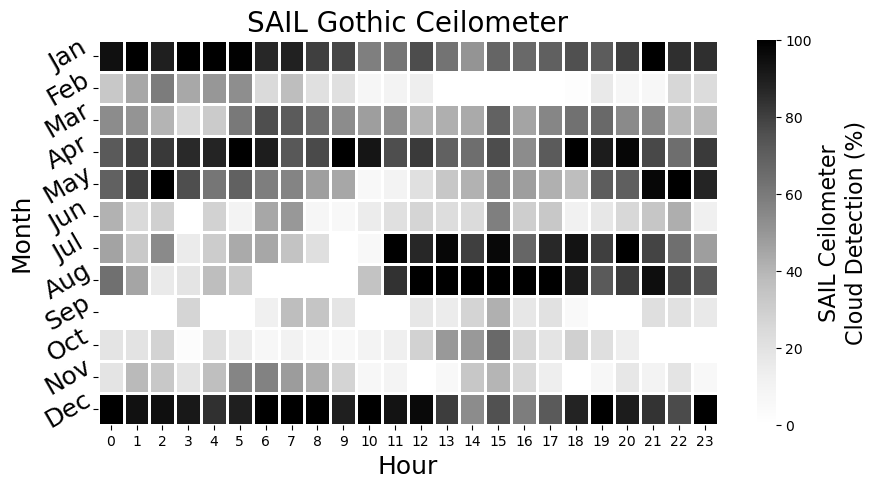

In [97]:
import seaborn as sns
fig, ax=plt.subplots(ncols=1,figsize=(10,5), facecolor='w')

# months = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.heatmap(ceil_df_hourly_cp, cmap='Greys', vmin=0, vmax=100,linewidths=2, cbar_kws={'label':'SAIL Ceilometer\nCloud Detection (%)'}, ax=ax)
# ax.set_xticklabels(ceil_df_hourly.columns, rotation=0, ha='right', size=18);
ax.set_yticklabels(months, rotation=30, ha='center', size=18);
ax.tick_params(axis='y', which='major', pad=18)
ax.set_xlabel('Hour',size=18)
ax.set_ylabel('Month', size=18)
ax.set_title('SAIL Gothic Ceilometer', size=20)
ax.figure.axes[-1].yaxis.label.set_size(16)
